`author:` Prashant Prasad Kanth </br>
 `date:` 10/13/2022 'MM/DD/YYY'

In [ ]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-memory 12G --executor-memory 12G\
                                     --packages graphframes:graphframes:0.8.2-spark3.2-s_2.12 pyspark-shell'

from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import count, col, array_sort, array
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

from graphframes import *
from graphframes.examples import Graphs

import numpy as np
import pandas as pd
import random
from collections import OrderedDict
import matplotlib.pyplot as plt
from numpy.linalg import norm

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [ ]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

:: loading settings :: url = jar:file:/koko/system/anaconda/envs/python38/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /common/home/ppk31/.ivy2/cache
The jars for the packages stored in: /common/home/ppk31/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1129a303-0280-4e5e-bbbf-a45560112f13;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 510ms :: artifacts dl 50ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------

### **Dataset 1: data.txt**

#### **Step 1:** Divide each entry by the Euclidean norm of the vector only if the norm of the vector is not equal to zero. Choose a threshold, t_1 such that up to 10,000 vectors have Euclidean norm > t_1

In [ ]:
def normalize(row):
    #vec = np.fromstring(row[1:len(row)], sep=',')
    vec = np.array([float(i.strip()) for i in row[1:len(row)-1].split(',')])
    euclidean_norm = norm(vec, ord=2)
    if euclidean_norm != 0:
        norm_vec = vec/euclidean_norm
        return (norm_vec.tolist(), float(euclidean_norm))

In [ ]:
lines = sc.textFile('data.txt')
vectors = lines.map(normalize)\
          .zipWithIndex()\
          .filter(lambda x: x[0] is not None)\
          .sortBy(lambda x: x[0][1], ascending=False)\
          .map(lambda x: (x[1], x[0][0], x[0][1]))
index = 10000
# rec = ((id, vector, norm), index)
t_1 = vectors.zipWithIndex()\
      .filter(lambda rec: rec[1] == index)\
      .map(lambda rec: rec[0][2])\
      .collect()[0]
print(f'Threshold t_1: {t_1}')
cols = ["id", "vector", "norm"]
vertices = vectors.toDF(cols)
vertices = vertices.filter(col("norm") > t_1)
vertices.show(n=5, truncate=False)
print(f"Total vertices: {vertices.count()}")

Threshold t_1: 31447.059269109537


+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|id    |vector                                                                                                                                                                                                                                                                                                                                                                                                                                |norm             |
+------+--------------------------------------------------------------------------------------------

Total vertices: 10000


#### **Step 2:** Connect a vector u to a vector v if the dot product of the normalized vector u with the normalized vector v is greater than a threshold t, where t, is a value greater than 0 and less than 1. Call this graph $G_{t}$.

In [ ]:
norm_vectors = vertices.toPandas()
# make Graph
th_vectors = np.array(norm_vectors.vector.tolist())
corr = th_vectors @ th_vectors.T
# choose threshold as 0.65
t = 0.65
corr = (corr > t).astype(int)
# avoid self-loops/diaognal
np.fill_diagonal(corr, 0)
# take indexes that satisy threshold
xy = np.where(corr == 1)
coord_list = list(zip(xy[0],xy[1]))
G_t = []
# put original node indexes from dataframe
for coord in coord_list:
    u = int(norm_vectors['id'].iloc[coord[0]])
    v = int(norm_vectors['id'].iloc[coord[1]])
    G_t.append((u, v))

#### **Step 3:** Compute the degree of every vertex in the graph $G_{t}$. Recall that the degree of a vertex is its number of neighbors.

In [ ]:
degree_dict = {}
for coord in G_t:
    degree_dict[coord[0]] = degree_dict.get(coord[0], 0) + 1

#### **Step 4:** Direct an edge from u to v if the degree of u is less than the degree of v. In case of ties choose the direction randomly. Call this graph $\hat{G_t}$.

In [ ]:
g_t_hat = []
for coord in G_t:
    u, v = coord
    if degree_dict[u] < degree_dict[v]:
        g_t_hat.append((u, v))
    elif degree_dict[u] == degree_dict[v]:
        if random.uniform(0, 1) > 0.5:
            g_t_hat.append((u, v))
        else:
            g_t_hat.append((v, u))
cols = ["src", "dst"]
e = sc.parallelize(g_t_hat)
edges = e.toDF(cols)
#edges.show(n=5, truncate=False)
print(f"Total edges: {edges.count()}")

# make graph G_t_hat
G_t_hat = GraphFrame(vertices, edges)
G_t_hat.edges.show(n=5)

Total edges: 61980
+------+------+
|   src|   dst|
+------+------+
|535075|190981|
|190981| 30134|
|190981|863315|
|165459|978902|
|165459|263129|
+------+------+
only showing top 5 rows



#### **Task 1:** Compute the in degree and out degree distribution of $\hat{G_t}$. Submit a plot. Please report the number of vertices and the number of edges in the graph.

In [ ]:
in_degree = G_t_hat.inDegrees.rdd.map(lambda row: (row.inDegree, 1))\
            .reduceByKey(lambda a,b: (a+b))\
            .collect()
out_degree = G_t_hat.outDegrees.rdd.map(lambda row: (row.outDegree, 1))\
             .reduceByKey(lambda a,b: (a+b))\
             .collect()

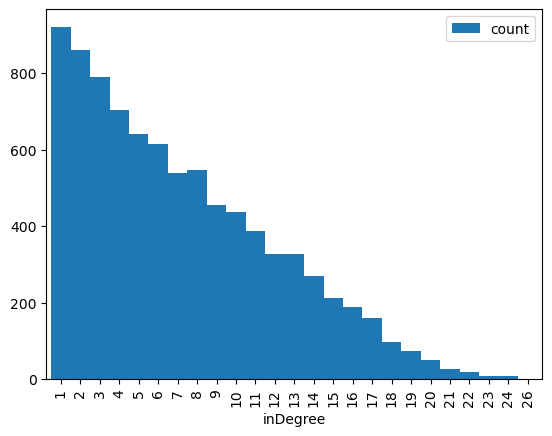

In [ ]:
in_degree = sc.parallelize(in_degree).toDF(['inDegree','count']).orderBy('inDegree')
in_degree = in_degree.toPandas()

ax = in_degree.plot(kind="bar", x = "inDegree", y = "count", width=1.0, rot=90)
plt.show()

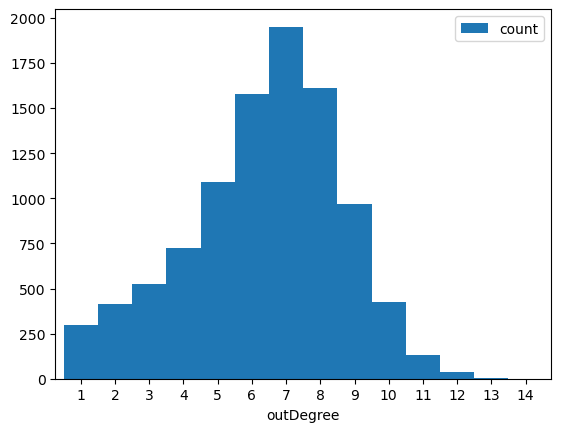

In [ ]:
out_degree = sc.parallelize(out_degree).toDF(['outDegree','count']).orderBy('outDegree')
out_degree = out_degree.toPandas()

ax = out_degree.plot(kind="bar", x = "outDegree", y = "count", width=1.0, rot=0)
plt.show()

In [ ]:
print(f"Total vertices: {G_t_hat.vertices.count()}")
print(f"Total edges: {G_t_hat.edges.count()}")

Total vertices: 10000
Total edges: 61980


#### **Task 2:** Compute the page rank of the graph $\hat{G_t}$ and submit the vertex_ids of top 100 page rank value.

In [ ]:
# Note that this is not the "normalized" PageRank and as a consequence pages that have no
# inlinks will have a PageRank of alpha. In particular, the pageranks may have some values
# greater than 1.
# `alpha` is the random reset probability (typically 0.15)

results = G_t_hat.pageRank(resetProbability=0.15, tol=0.01)

In [ ]:
# normalizing page rank results

pr_sum = results.vertices.agg({'pagerank': 'sum'}).rdd.flatMap(lambda x: x).collect()[0]
pagerank_normalized = results.vertices.rdd.map(lambda x: (x.id, x.vector, x.norm, x.pagerank/pr_sum))\
                      .toDF(['id', 'vector', 'norm', 'pagerank'])\
                      .orderBy("pagerank", ascending=False)
pagerank_normalized.select("id", "pagerank").show(n=100, truncate=False)

+------+---------------------+
|id    |pagerank             |
+------+---------------------+
|405736|0.005637919929679328 |
|121728|0.0037903352477082646|
|1600  |0.003616166543818808 |
|311644|0.0034449295930388917|
|94769 |0.003298517584336173 |
|899318|0.003254061840430126 |
|165154|0.00323153531244964  |
|548412|0.003231241852748723 |
|371566|0.002973013778734934 |
|363625|0.0028674725821913054|
|519725|0.0028635967700015278|
|732321|0.0028620847457053755|
|935515|0.002834850055631458 |
|548683|0.0027932403526748774|
|818934|0.002756473307527042 |
|692715|0.0027009981843489415|
|946132|0.00263639224454277  |
|522927|0.0026289366759615633|
|214540|0.0026245820278913414|
|369706|0.002538813830582774 |
|423771|0.0025372770267793874|
|336338|0.002502308414636914 |
|917368|0.0023875404722415007|
|913927|0.002368262264095742 |
|113954|0.0022769427724335664|
|280848|0.002054377262923815 |
|710746|0.002003137808288394 |
|585343|0.0019855982695344493|
|199616|0.0018780497170442162|
|966395|

#### **Task 3:** Standardize the page rank values of the graph using the formula $(page\_rank\_i – min(page\_rank\_values)) \over (max(page\_rank\_values) - min(page\_rank\_values))$. Plot this distribution standardized(page_rank) on x-axis and the number of vertices on the y-axis. Also, please indicate clearly the mean and standard deviation of this distribution.

In [ ]:
min_pr = pagerank_normalized.agg({'pagerank': 'min'}).rdd.flatMap(lambda x: x).collect()[0]
max_pr = pagerank_normalized.agg({'pagerank': 'max'}).rdd.flatMap(lambda x: x).collect()[0]
standardized_page_rank = pagerank_normalized.select("id", "pagerank").rdd\
                        .map(lambda row: (row.id, (row.pagerank-min_pr)/(max_pr-min_pr)))\
                        .toDF(['id', 'pagerank'])

In [ ]:
std_pr_cnt_df = standardized_page_rank.toPandas().pagerank.value_counts().reset_index()
std_pr_cnt_df = std_pr_cnt_df.rename(columns={"pagerank": "count", "index": "pagerank"})

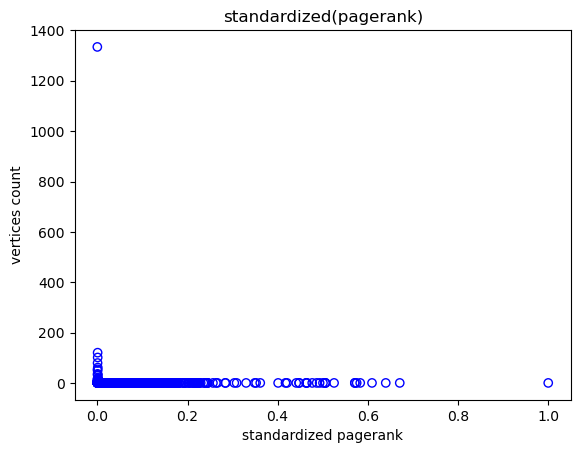

In [ ]:
plt.scatter(std_pr_cnt_df['pagerank'], std_pr_cnt_df['count'], color="none", edgecolor="blue")
plt.xlabel('standardized pagerank')
plt.ylabel('vertices count')
plt.title('standardized(pagerank)')
plt.show()

In [ ]:
mean = standardized_page_rank.agg({'pagerank': 'avg'}).rdd.flatMap(lambda x: x).collect()[0]
stddev = standardized_page_rank.agg({'pagerank': 'stddev'}).rdd.flatMap(lambda x: x).collect()[0]
print(f'Mean: {mean}, Standard Deviation: {stddev}')

Mean: 0.013000386456937992, Standard Deviation: 0.03636881815718505


#### **Task 4:** Implement a method which takes vertex_id as input and return the corresponding (page_rank, standardized page_rank) values.

In [ ]:
def get_details(idx):
    pr = pagerank_normalized.rdd.filter(lambda row: row.id==idx).map(lambda row: row.pagerank).collect()[0]
    stdrd_pr = standardized_page_rank.rdd.filter(lambda row: row.id==idx).map(lambda row: row.pagerank).collect()[0]
    return pr, stdrd_pr

In [ ]:
idx = 932
pr, stdrd_pr = get_details(idx)
print(f'id: {idx}, page_rank: {pr}, standardized_page_rank: {stdrd_pr}')

id: 932, page_rank: 0.0010265761599305174, standardized_page_rank: 0.17814006405834218


### **Dataset 2: layer-175.csv**

In [ ]:
def mapper(e):
    row = e.split(',')
    return (int(row[0].strip()), int(row[1].strip()))

In [ ]:
def edgeMapper(e, degree_dict):
    u = int(e[0])
    v = int(e[1])
    if degree_dict[u] < degree_dict[v]:
        return (u, v, sorted(e))
    elif degree_dict[u] == degree_dict[v]:
        if random.uniform(0, 1) > 0.5:
            return (u, v, sorted(e))
        else:
            return (v, u, sorted(e))

def getKey(e):
    return "{0}{1}".format(e[2][0],e[2][1])

#### **Step 3:** Compute the degree of every vertex in the graph $G_{t}$. Recall that the degree of a vertex is its number of neighbors.

In [ ]:
rows = sc.textFile('layer-175.csv')
G_t = rows.map(mapper)
degree_dict = G_t.map(lambda e: (e[0], 1))\
              .reduceByKey(lambda a,b: (a+b))\
              .collectAsMap()
vertices = sc.parallelize(list(degree_dict.keys()))
vertices = vertices.map(lambda x: (x, )).toDF(['id'])

#### **Step 4:** Direct an edge from u to v if the degree of u is less than the degree of v. In case of ties choose the direction randomly.

In [ ]:
cols = ['src','dst']
edges = G_t.map(lambda e: edgeMapper(e, degree_dict))\
         .filter(lambda e: e is not None)

# remove duplicates
edges = edges.map(lambda e: (getKey(e), (e[0],e[1])))\
        .reduceByKey(lambda x,y: x)\
        .map(lambda row: (row[1][0], row[1][1]))\
        .toDF(cols)

# make graph G_t_hat
G_t_hat = GraphFrame(vertices, edges)

#### **Task 1:** Compute the in degree and out degree distribution of $\hat{G_t}$. Submit a plot. Please report the number of vertices and number of edges 

In [ ]:
in_degree = G_t_hat.inDegrees.rdd.map(lambda row: (row.inDegree, 1))\
            .reduceByKey(lambda a,b: (a+b))\
            .collect()

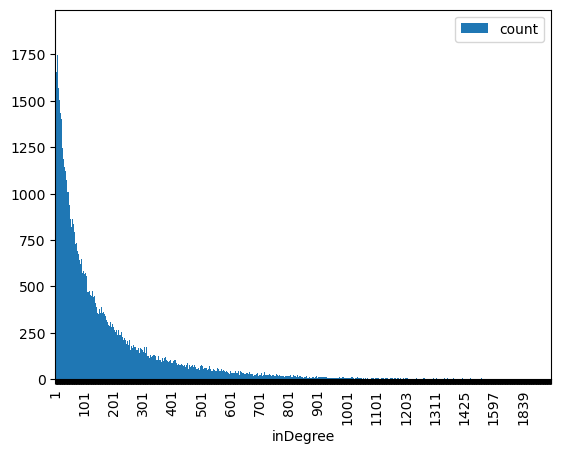

In [ ]:
in_degree = sc.parallelize(in_degree).toDF(['inDegree','count']).orderBy('inDegree')
in_degree = in_degree.toPandas()

ax = in_degree.plot(kind="bar", x = "inDegree", y = "count", width=1.0, rot=90)
ax.set_xticklabels([t if not i%100 else "" for i,t in enumerate(ax.get_xticklabels())])
plt.show()

In [ ]:
out_degree = G_t_hat.outDegrees.rdd.map(lambda row: (row.outDegree, 1))\
             .reduceByKey(lambda a,b: (a+b))\
             .collect()

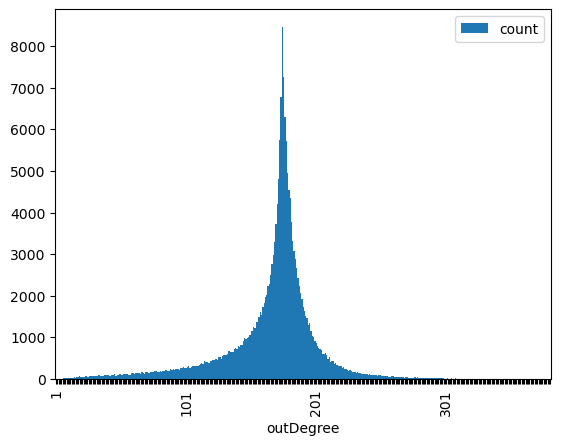

In [ ]:
out_degree = sc.parallelize(out_degree).toDF(['outDegree','count']).orderBy('outDegree')
out_degree = out_degree.toPandas()

ax = out_degree.plot(kind="bar", x = "outDegree", y = "count", width=1.0, rot=90)
ax.set_xticklabels([t if not i%100 else "" for i,t in enumerate(ax.get_xticklabels())])
plt.show()

In [ ]:
print(f"Total vertices: {G_t_hat.vertices.count()}")
print(f"Total edges: {G_t_hat.edges.count()}")

Total vertices: 197091


Total edges: 32971011


#### **Task 2:** Compute the page rank of the graph $\hat{G_t}$ and submit the vertex_ids of top 100 page rank value.

In [ ]:
results = G_t_hat.pageRank(resetProbability=0.15, tol=0.01)

In [ ]:
pr_sum = results.vertices.agg({'pagerank': 'sum'}).rdd.flatMap(lambda x: x).collect()[0]
pagerank_normalized = results.vertices.rdd.map(lambda x: (x.id, x.pagerank/pr_sum))\
                      .toDF(['id', 'pagerank'])\
                      .orderBy("pagerank", ascending=False)
pagerank_normalized.show(n=100, truncate=False)

+--------+---------------------+
|id      |pagerank             |
+--------+---------------------+
|38251780|0.03154930508379358  |
|39015975|0.021545427848443533 |
|37633549|0.01100415027066301  |
|41102009|0.009609127054331493 |
|47212248|0.007690220014590971 |
|22088869|0.007492302929135414 |
|46851229|0.00629742592058165  |
|49466286|0.00543271483333296  |
|34509780|0.0051781663722609474|
|33006741|0.0038526896654794197|
|37881643|0.0035157254838625845|
|37573014|0.0032985361328523814|
|30094942|0.00318662540861436  |
|62491219|0.002967731107261224 |
|29719815|0.002928101594261852 |
|48388243|0.002904661087985973 |
|38053487|0.002883821643656644 |
|46051746|0.002729728019150555 |
|43003276|0.002641872863063968 |
|34534249|0.002560333816202608 |
|60766523|0.0025219940321520124|
|46921354|0.002439376066251749 |
|39470974|0.0023978540664195067|
|56140216|0.0023455765960532582|
|65088440|0.0022268079635824295|
|28080724|0.0022203229273377325|
|43307277|0.001995235538530884 |
|32806769|

#### **Task 3:** Standardize the page rank values of the graph using the formula $(page\_rank\_i – min(page\_rank\_values)) \over (max(page\_rank\_values) - min(page\_rank\_values))$. Plot this distribution standardized(page_rank) on x-axis and the number of vertices on the y-axis. Also, please indicate clearly the mean and standard deviation of this distribution.

In [ ]:
min_pr = pagerank_normalized.agg({'pagerank': 'min'}).rdd.flatMap(lambda x: x).collect()[0]
max_pr = pagerank_normalized.agg({'pagerank': 'max'}).rdd.flatMap(lambda x: x).collect()[0]
standardized_page_rank = pagerank_normalized.rdd\
                        .map(lambda row: (row.id, (row.pagerank-min_pr)/(max_pr-min_pr)))\
                        .toDF(['id', 'pagerank'])

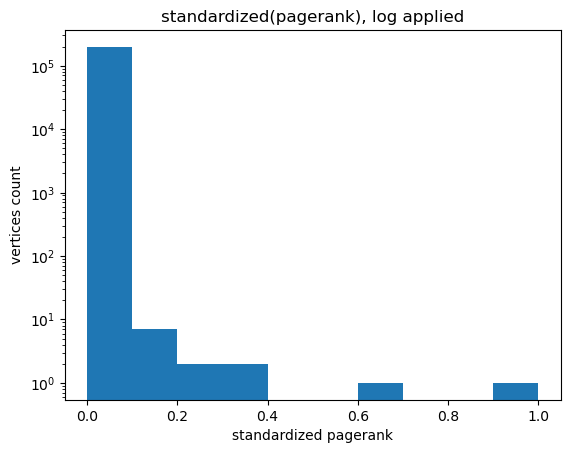

In [ ]:
std_pr_cnt_df = standardized_page_rank.toPandas()

plt.hist(x = std_pr_cnt_df['pagerank'], log=True)
plt.xlabel('standardized pagerank')
plt.ylabel('vertices count')
plt.title('standardized(pagerank), log applied')
plt.show()

In [ ]:
mean = standardized_page_rank.agg({'pagerank': 'avg'}).rdd.flatMap(lambda x: x).collect()[0]
stddev = standardized_page_rank.agg({'pagerank': 'stddev'}).rdd.flatMap(lambda x: x).collect()[0]
print(f'Mean: {mean}, Standard Deviation: {stddev}')

Mean: 0.00013014981400393663, Standard Deviation: 0.0033201966900718916


#### **Task 4:** Implement a method which takes vertex_id as input and return the corresponding (page_rank, standardized page_rank) values.

In [ ]:
def get_details(idx):
    pr = pagerank_normalized.rdd.filter(lambda row: row.id==idx).map(lambda row: row.pagerank).collect()[0]
    stdrd_pr = standardized_page_rank.rdd.filter(lambda row: row.id==idx).map(lambda row: row.pagerank).collect()[0]
    return pr, stdrd_pr

In [ ]:
idx = 43307277
pr, stdrd_pr = get_details(idx)
print(f'id: {idx}, page_rank: {pr}, standardized_page_rank: {stdrd_pr}')

id: 43307277, page_rank: 0.001995235538530884, standardized_page_rank: 0.0632130857381437
